In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#plt.style.use("seaborn")

df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2025/refs/heads/main/data/loan_data.csv')
df.head()

,ApplicationNumber,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,MonthlyLoanPayment,MonthlyIncome,JobTenure,LoanApproved
0,26231,18,"$26,992.00",586,Employed,Diploma,"$22,432.00",36 months,Single,3,Mortgage,0,Debt Consolidation,0,$623.11,"$2,249.33",3,No
1,13176,18,"$22,825.00",581,Self-Employed,Master,"$30,457.00",24 months,Single,0,Rent,0,Home Improvement,0,"$1,269.04","$1,902.08",5,No
2,27751,18,"$75,891.00",522,Employed,Bachelor,"$30,583.00",96 months,Married,2,Mortgage,0,Personal,0,$318.57,"$6,324.25",6,No
3,20628,18,"$92,094.00",565,Employed,Bachelor,"$72,738.00",36 months,Single,1,Mortgage,0,Vehicle,0,NaN,"$7,674.50",3,No
4,28773,18,"$35,686.00",554,Employed,Diploma,"$28,021.00",36 months,Married,3,Rent,0,Home Improvement,0,$778.36,"$2,973.83",1,No


In [2]:
# general info about dataset: columns, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ApplicationNumber     20000 non-null  int64 
 1   Age                   20000 non-null  int64 
 2   AnnualIncome          20000 non-null  object
 3   CreditScore           20000 non-null  int64 
 4   EmploymentStatus      16260 non-null  object
 5   EducationLevel        20000 non-null  object
 6   LoanAmount            20000 non-null  object
 7   LoanDuration          20000 non-null  object
 8   MaritalStatus         20000 non-null  object
 9   NumberOfDependents    20000 non-null  int64 
 10  HomeOwnershipStatus   20000 non-null  object
 11  BankruptcyHistory     20000 non-null  int64 
 12  LoanPurpose           20000 non-null  object
 13  PreviousLoanDefaults  20000 non-null  int64 
 14  MonthlyLoanPayment    15660 non-null  object
 15  MonthlyIncome         17160 non-null

In [3]:
# Identify numeric columns and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Correlation matrix for numeric columns
corr = df.corr(numeric_only=True)

First provides general information about the dataset, this shows the number of rows and columns, each columns name, the count of non-missing values, and the data type of each column, which is useful for quickly understanding the structure of the dataset, identifying columns with missing data.

Next, identifies numeric and categorical columns, where columns with object data type strings or categorical values are stored. This separation is important because numeric and categorical data are often preprocessed differently.

Finally, calculates a correlation matrix for the numeric columns the correlation matrix measures linear relationships between numeric variables, producing values between -1 and 1.

Where correlation of 1 indicates a perfect positive relationship, -1 a perfect negative relationship, and 0 no linear relationship.

In [4]:
df.drop_duplicates(inplace=True) # Remove duplicate rows

df.columns = df.columns.str.strip().str.replace(" ", "_") # Clean column names

# Define a function to convert numeric strings to numeric values
def clean_numeric(x):
    if isinstance(x, str):  # Check if the value is a string
        x = x.replace("$", "").replace(",", "").replace("%", "").strip()  # Remove currency symbols, commas, percent signs, and extra spaces
    return pd.to_numeric(x, errors="coerce")  # Convert to numeric, set invalid values to NaN

# List of object columns that should be numeric
numeric_string_cols = ['AnnualIncome', 'LoanAmount', 'LoanDuration', 'MonthlyLoanPayment', 'MonthlyIncome', 'CreditScore',
                       'NumberOfDependents','JobTenure','BankruptcyHistory','PreviousLoanDefaults']

# Apply the numeric conversion function to the listed columns if they exist in the dataset
for col in numeric_string_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_numeric)

# Separate numeric and categorical columns for further processing
num_cols = df.select_dtypes(include=['int64', 'float64']).columns  # Numeric columns
cat_cols = df.select_dtypes(include=['object']).columns            # Categorical columns

# Impute missing numeric values using the median of each column
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Impute missing categorical values with the most frequent value (mode) and clean the text
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values with mode
    df[col] = df[col].astype(str).str.strip().str.title()  # Remove extra spaces and capitalize words

# Automatically encode binary categorical columns (Yes/No, True/False, Y/N)
binary_map = {"yes": 1, "no": 0, "true": 1, "false": 0, "y": 1, "n": 0}

for col in cat_cols:
    col_lower = df[col].astype(str).str.lower().str.strip()  # Convert text to lowercase and remove spaces
    df[col] = col_lower.map(binary_map).fillna(df[col])  # Map known binary values to 0/1, leave other values unchanged

# If MonthlyIncome column is missing but AnnualIncome exists, calculate MonthlyIncome
if "MonthlyIncome" not in df.columns and "AnnualIncome" in df.columns:
    df["MonthlyIncome"] = df["AnnualIncome"] / 12  # Divide annual income by 12 to get monthly income

# Ensure key numeric columns are of numeric type for calculations
for col in ["MonthlyIncome", "MonthlyLoanPayment"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid values become NaN

df.head() # Show the rows of the cleaned dataset

,ApplicationNumber,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,MonthlyLoanPayment,MonthlyIncome,JobTenure,LoanApproved
0,26231,18,26992.0,586,Employed,Diploma,22432.0,NaN,Single,3,Mortgage,0,Debt Consolidation,0,623.110,2249.33,3,0
1,13176,18,22825.0,581,Self-Employed,Master,30457.0,NaN,Single,0,Rent,0,Home Improvement,0,1269.040,1902.08,5,0
2,27751,18,75891.0,522,Employed,Bachelor,30583.0,NaN,Married,2,Mortgage,0,Personal,0,318.570,6324.25,6,0
3,20628,18,92094.0,565,Employed,Bachelor,72738.0,NaN,Single,1,Mortgage,0,Vehicle,0,439.185,7674.50,3,0
4,28773,18,35686.0,554,Employed,Diploma,28021.0,NaN,Married,3,Rent,0,Home Improvement,0,778.360,2973.83,1,0


first removes duplicate rows from the DataFrame df to ensure all entries are unique.

Then, standardizes the column names by stripping leading and trailing spaces and replacing internal spaces with underscores for easier reference, where a function clean_numeric is defined to convert numeric-like strings into actual numbers as it removes symbols like $, %, and , from strings, trims whitespace, and converts the result to a numeric type, coercing any non-convertible values to NaN.

where , this function is applied to columns that should be numeric but may currently be stored as strings, such asAnnualIncome', 'LoanAmount','LoanDuration', 'MonthlyLoanPayment', 'MonthlyIncome', 'CreditScore' 'NumberOfDependents','JobTenure','BankruptcyHistory','PreviousLoanDefaults.

Next, the code separates numeric columns from categorical columns to handle missing values differently. Numeric columns have missing values filled with the column median, while categorical columns have missing values filled with the mode.

Then, binary categorical columns, like Yes/No or True/False, are automatically encoded as 1 and 0 using a mapping dictionary. If MonthlyIncome is missing but AnnualIncome is present, it is calculated by dividing annual income by 12.

Finally, key numeric columns such as MonthlyIncome and MonthlyLoanPayment are ensured to be numeric to support calculations. so, the code provides a complete data cleaning and preprocessing pipeline for numeric and categorical data, handling duplicates, formatting, missing values, and binary encoding.

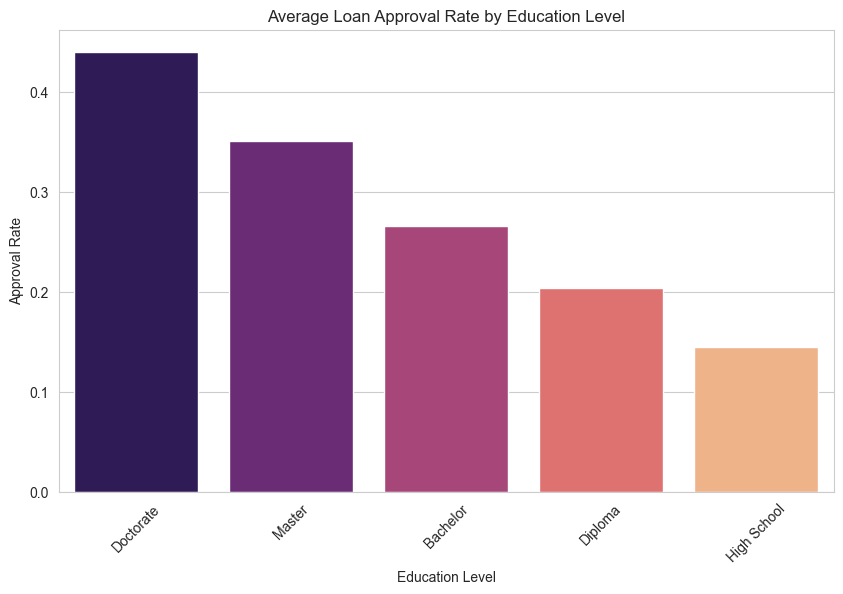

In [5]:
sns.set_style("whitegrid") # Set the background style of the plot

df['LoanApproved_num'] = df['LoanApproved'].map({'Yes':1, 'No':0}) # Encode LoanApproved to numerical values

approval_rates = df.groupby('EducationLevel')['LoanApproved'].mean().sort_values(ascending=False) # Group by EducationLevel and calculate the mean approval rate

# compute the average of the numeric LoanApproved values for each education level
# sort the approval rates in descending order
plt.figure(figsize=(10, 6)) # Plot the bar chart

# X-axis: Education levels, Y-axis: Corresponding average approval rates, hue uses education level, Color palette used for bars, Hide the legend
sns.barplot(x=approval_rates.index, y=approval_rates.values, hue=approval_rates.index, palette='magma', legend=False)

plt.title('Average Loan Approval Rate by Education Level') # Set the plot title

plt.xlabel('Education Level')  # Set X-axis label

plt.ylabel('Approval Rate') # Set Y-axis label

plt.xticks(rotation=45) # Rotate X-axis labels for better readability

plt.show() # Show the plot

The educational level with the highest average approval rate is Doctorate.

We choose a bar chart because the question asks to compare the average approval rate which is numeric across different education levels which is categorical, so bar chart is good for showing how a numeric value varies across categories.

The code:

First set plot style to set the background style of the plots to a white grid.

Next convert the LoanApproved column to a categorical type which makes it possible to calculate numerical statistics like the mean

Then calculate average approval rate by education level after that group the dataset by educationLevel column

Then compute the mean of the numeric LoanApproved values for each group, then sort the results in descending order so the highest approval rates appear first.

After that set figure size then plot the bar chart:

x=approval_rates.index for the education levels on the X-axis.

y=approval_rates.values for the corresponding average approval rates on the Y-axis.

hue=approval_rates.index to color bars by category.

palette='magma' to choose the color theme.

legend=False to hide the legend.

Add Plot Labels and Title

Next, rotate the X-axis labels by 45 degrees to avoid overlapping text, finally show the Plot.

Quartiles of Annual Income among approved applicants:
0.25     67380.5
0.50     91269.5
0.75    123959.5
Name: AnnualIncome, dtype: float64


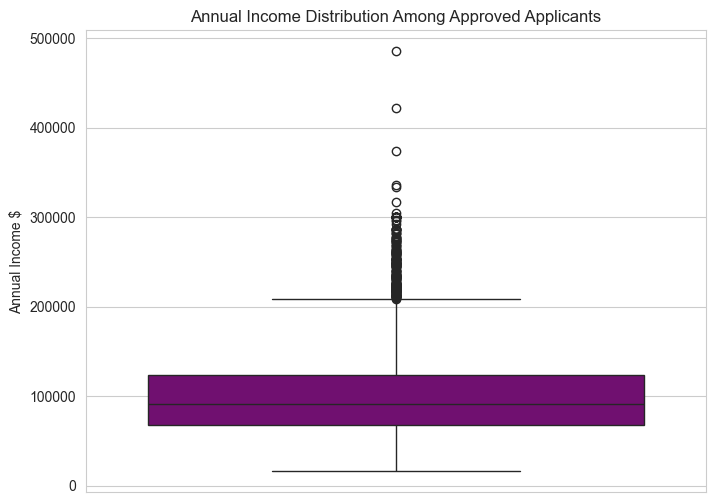

In [6]:
sns.set_style("whitegrid")  # Set the background style of the plot

approved_df = df[df['LoanApproved'] == 1].copy() # Filter approved applicants

if approved_df.empty:  # If there are no approved applicants in the dataset
    print("No approved applicants in the dataset!")  # Print a warning message
else:
    quartiles = approved_df['AnnualIncome'].quantile([0.25, 0.5, 0.75])  # Calculate 25th, 50th (median), and 75th percentiles
    print("Quartiles of Annual Income among approved applicants:")  # Print heading
    print(quartiles)  # Show the calculated quartiles

    plt.figure(figsize=(8, 6))  # Set the figure size for the plot
    sns.boxplot(y=approved_df['AnnualIncome'], color='purple')  # Create a vertical boxplot of AnnualIncome with purple color
    plt.title('Annual Income Distribution Among Approved Applicants')  # Add a title to the plot
    plt.ylabel('Annual Income $')  # Label the y-axis
    plt.show()  # Display the boxplot

The annual income among approved applicants shows a wide variation. The first quartile is 67,380.5, which means that 25% of approved applicants earn less than this amount. The median is 91,269.5, indicating that half of the approved applicants earn below this value and half earn above it. The third quartile is 123,959.5, meaning that 75% of approved applicants earn less than this amount, while the top 25% earn more.

The boxplot shows a middle 50% the box but also there is a number of high income outliers above, which confirming that some approved applicants earn much more.

Interpretation of the 3 quartiles

Q1 (25% = 67,380): 25% of approved applicants earn less than 67,367.

Q2 (50% = 91,269): 50% of approved applicants earn less than 91,274, half earn more.

Q3 (75% = 123,959): 25% of approved applicants earn more than 123,816.

The middle 50% of applicants earn between 67,380 and 123,959, in addition there is a focus around the median with gradual spread. Moreover, the income variation among approved applicants is large, showing diversity in income.

We choose box plot because the question asks about how annual income varies among approved applicants, so boxplot effectively shows the spread of the data, highlighting the median, quartiles and outliers.

The code:

First set the plot style whitegrid, which applies a clean white background with gridlines to make the visualization easier to read.

Then, the dataset is then filtered to include only approved applicants by selecting rows where the LoanApproved column equals 1. A check ensures that there are approved applicants in the dataset if none exist, then a warning message is printed.

Next, the code calculates the quartiles (25th, 50th, and 75th percentiles) of the AnnualIncome column for the approved applicants and prints them, which provides a summary of the income distribution, showing the lower quartile, median, and upper quartile.

Correlation between Age and CreditScore: 0.3232427968850229


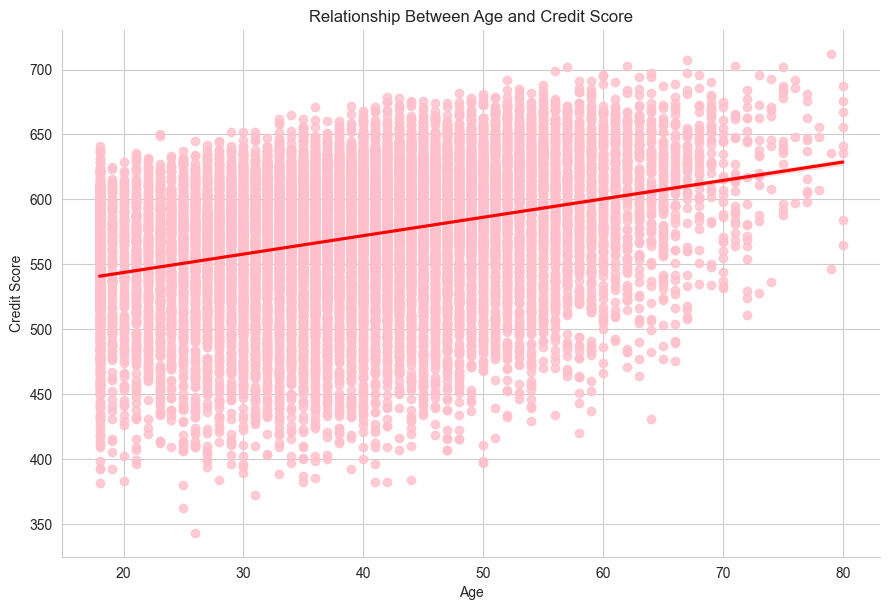

In [7]:
sns.set_style("whitegrid") # Set the background style of plots to a white grid

df['Age'] = pd.to_numeric(df['Age'], errors='coerce') # Convert Age to numeric, invalid values become NaN

df['CreditScore'] = pd.to_numeric(df['CreditScore'], errors='coerce') # Convert CreditScore to numeric, invalid values become NaN

df = df.dropna(subset=['Age', 'CreditScore']) # Remove any rows where Age or CreditScore is missing (NaN)

correlation = df['Age'].corr(df['CreditScore'])  # Calculate the correlation between Age and CreditScore
print("Correlation between Age and CreditScore:", correlation) #Print correlation

# Choose columns for the x-axis and y-axis, set the figure size, make the scatter points pink, make the regression line red
sns.lmplot(x='Age', y='CreditScore', data=df, height=6, aspect=1.5,scatter_kws={'color': 'pink'}, line_kws={'color': 'red'})

plt.title('Relationship Between Age and Credit Score') # Add a title to the plot

plt.xlabel('Age') # Label the x-axis

plt.ylabel('Credit Score') # Label the y-axis

plt.show() # Show the final plot

According to the chart as the age of an applicant increases, their credit score also tends to increase. Moreover, the chart shows a positive trend between age and credit score, indicated by the upward sloping red regression line. This shows that older applicants generally have higher credit scores than younger ones, although there is still large difference within each age group which is shown by the spread of points.

We choose a scatter plot with regression line because the question asks how Age affects Credit Score which involves analyzing the relationship between two continuous numeric variables, so scatter plot shows each applicant as a point, making patterns or trends visible and the added line of best fit highlights the general trend in the data which makes it easy to see whether credit score tends to increase, decrease, or remain constant as age changes.

The code:

First set the style of Seaborn plots to whitegrid which gives all plots a clean white background with grid lines, making data points and trends easier to see.

Next, converts the Age and CreditScore columns in the DataFrame df to numeric values, also any invalid or non-numeric entries in these columns are converted to NaN to prevent errors in calculations.

After that, remove any rows where either Age or CreditScore is missing, ensuring that all calculations and plots only use valid data.

Then calculates the Pearson correlation coefficient between Age and CreditScore. This correlation measures the strength and direction of the linear relationship between the two variables. A value close to 1 indicates a strong positive correlation, a value close to -1 indicates a strong negative correlation, and a value near 0 indicates little or no linear correlation.

Next, the code creates a scatter plot with a regression line. The x-axis represents Age, and the y-axis represents CreditScore. The figure size is set with height=6 and aspect=1.5, the scatter points are colored pink, and the regression line is colored red. This visualization helps to see both the distribution of data points and the trend of the relationship between age and credit score.

Finally, the code adds a title to the plot, and labels the x-axis and y-axis to make the plot easier to understand. The plot is showed, showing the scatter plot with the regression line for visual analysis.

2.2494896361607686


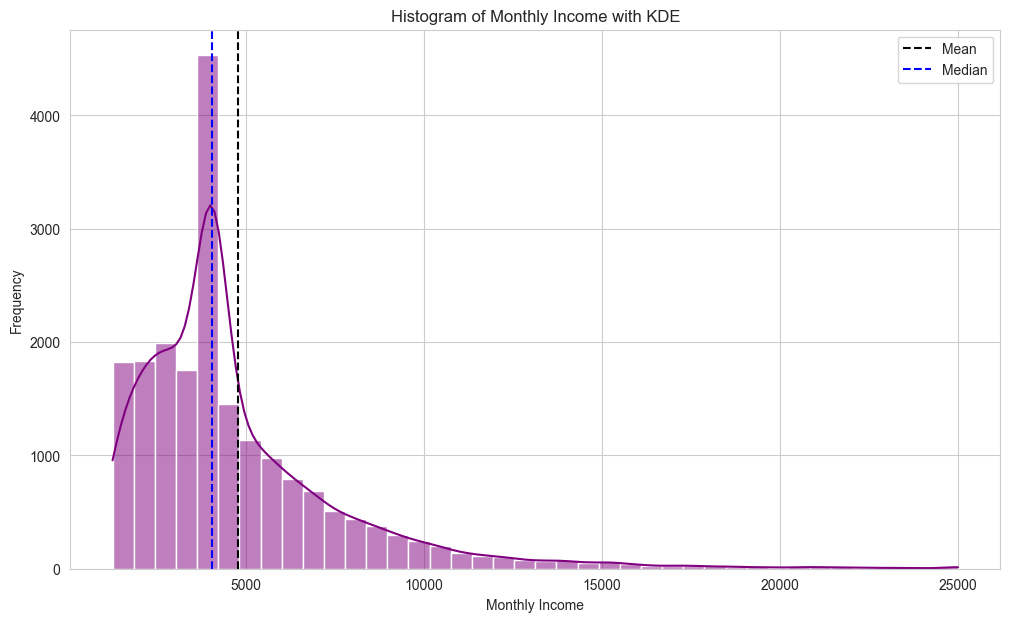

In [8]:
plt.figure(figsize=(12, 7))  # Create a figure of size 12x7 inches
sns.set_style("whitegrid")    # Set a clean white grid background for the plot

print(df['MonthlyIncome'].skew()) #show skewness

# Plot histogram using KDE which is kernel density estimate
sns.histplot( df['MonthlyIncome'], kde=True, bins=40, color='purple')

plt.title('Histogram of Monthly Income with KDE')  # Add a title to the plot
plt.xlabel('Monthly Income')                        # Label for x-axis
plt.ylabel('Frequency')                             # Label for y-axis

plt.axvline(df['MonthlyIncome'].mean(), color='black', linestyle='--', label='Mean')  # Mean line in black
plt.axvline(df['MonthlyIncome'].median(), color='blue', linestyle='--', label='Median')  # Median line in blue

plt.legend()  # Show the legend showing which line is mean and median
plt.show()    # Show the plot

The distribution of applicants monthly income is not normal, it is positively skewed which is right skewed. This can be seen in the histogram, where most values are focused on the left to the right. Additionally, the skewness statistic is 2.24, indicating right skew.

We choose a histogram with KDE because the question asks about the distribution of applicants monthly income which is a single continuous numeric variable, so histogram groups data into bins, showing how frequently values occur in each range and adding a KDE provides curve over the histogram, helping to visually identify the shape of the distribution, whether it is normal or skewed.

The code:

First set the style of all Seaborn plots to whitegrid, which provides a clean white background with grid lines. This makes the plots easier to read.

This code visualizes the distribution of applicants monthly income using a histogram with a kernel density estimate (KDE).

Then, purple color is used for the histogram bars, the plot is shown with a KDE curve to show the smooth distribution.

Next, two vertical dashed lines indicate the mean (black) and median (blue) monthly incomes, allowing easy comparison of the central tendency and potential skewness.

Finally, show the legend which shown which is mean and which is mediam then show the chart.

In [16]:
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing sets

df_encoded = df.copy() # Make a copy of the cleaned and preprocessed dataset to avoid modifying the original

y = df['LoanApproved'] # Extract the target variable LoanApproved for modeling

X = df_encoded.drop('LoanApproved', axis=1)  # Remove the target column from features to create X

print("Missing in X:", X.isnull().sum().sum())  # Total missing values in features
print("Missing in y:", y.isnull().sum())       # Total missing values in target


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Use 20% of data for testing, stratify ensures target proportion
)

print(f"Training set: {X_train.shape[0]} samples")  # Number of samples in the training set
print(f"Testing set: {X_test.shape[0]} samples")    # Number of samples in the testing set
print("Number of features:", X_train.shape[1])      # Number of features used for modeling

Missing in X: 40000
Missing in y: 0
Training set: 16000 samples
Testing set: 4000 samples
Number of features: 18


First, a copy of the preprocessed dataset (df_model) is made to ensure the original cleaned data remains unchanged.

Then, target variable (LoanApproved) is separated from the features, creating y for the target and X for the input features.

Next, safety check is performed to confirm that there are no missing values in either X or y.

Then, dataset is then split into training and testing sets, the stratify=y parameter ensures that the proportion of approved and non-approved loans is maintained in both training and testing sets.

Finally, the code prints the number of samples in each set and the number of features, confirming the shapes of the datasets before modeling.

In [10]:
from sklearn.tree import DecisionTreeClassifier

categorical_cols = X_train.select_dtypes(include=['object']).columns # Identify categorical columns in the training set

# One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True) # Convert categorical features to binary columns
X_test_encoded  = pd.get_dummies(X_test,  columns=categorical_cols, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0) # Match test to train columns


y_notnull = y_train.notnull() # Remove rows where y_train is NaN, True for rows where y_train is not NaN

X_train_encoded_clean = X_train_encoded[y_notnull] # Keep only rows in X_train corresponding to non-missing target
y_train_clean         = y_train[y_notnull] # Keep only non missing target values

# Train decision tree
dt_clf = DecisionTreeClassifier(random_state=42) # Create classifier with a fixed random state for reproducibility
dt_clf.fit(X_train_encoded_clean, y_train_clean) # Train the classifier on cleaned and encoded training data

y_pred = dt_clf.predict(X_test_encoded) # Predict target values for test features

First, the categorical columns in the training set were identified and one-hot encoded, converting each category into a separate binary column to allow the decision tree to handle categorical data properly.

Next, the same encoding was applied to the test set, and its columns were reorganized to match the training set, filling any missing columns with zeros to ensure consistent feature alignment between training and testing datasets.

Next, rows with missing target values (y_train) were removed to ensure the model was trained only on valid data.

Then, DecisionTreeClassifier was then initialized with a fixed random state for reproducibility, and trained on the cleaned and encoded training data (X_train_encoded_clean and y_train_clean).

Finally, the trained decision tree model was used to predict loan approval outcomes (y_pred) on the test dataset.

Accuracy: 0.84
Precision: 0.65
Recall: 0.69
F1-Score: 0.67
Training Accuracy: 1.00
Test Accuracy: 0.84
Overfitting: 16.25%


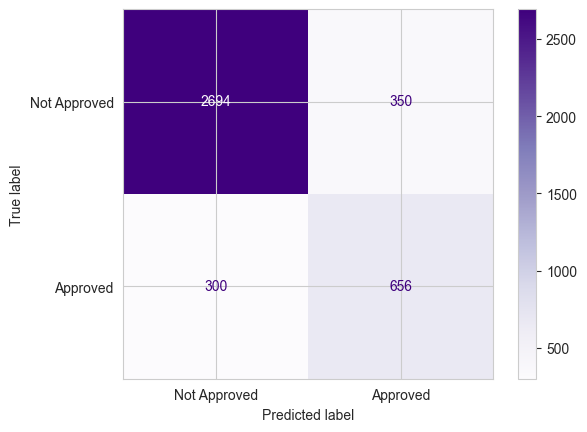

In [12]:
y_test_notnull = y_test.notnull()  #Clean y_test and align X_test
y_test_clean  = y_test[y_test_notnull]  # Keep only the non-missing values in y_test
X_test_clean = X_test_encoded[y_test_notnull]  # Filter features using the same mask
y_pred_clean = dt_clf.predict(X_test_clean) #predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay  # Import evaluation metrics
import matplotlib.pyplot as plt  # Import plotting library for visualization
from sklearn.tree import export_graphviz  # Import function to export decision tree to DOT format
import graphviz  # Import Graphviz to visualize decision trees

test_accuracy = accuracy_score(y_test_clean, y_pred_clean)  # Accuracy overall correctness
test_precision = precision_score(y_test_clean, y_pred_clean)  # Precision all predicted positives
test_recall = recall_score(y_test_clean, y_pred_clean)  # Recall correct positive predictions
test_f1 = f1_score(y_test_clean, y_pred_clean)  # F1-Score mean of precision and recall

# Training accuracy
y_train_pred = dt_clf.predict(X_train_encoded)
train_accuracy = accuracy_score(y_train, y_train_pred)

overfit_percent = (train_accuracy - test_accuracy) * 100 # Calculating overfitting percentage which is difference between training and test accuracy


print(f"Accuracy: {accuracy_score(y_test_clean, y_pred_clean):.2f}")  # show accuracy
print(f"Precision: {precision_score(y_test_clean, y_pred_clean):.2f}")  # show precision
print(f"Recall: {recall_score(y_test_clean, y_pred_clean):.2f}")  # show recall
print(f"F1-Score: {f1_score(y_test_clean, y_pred_clean):.2f}")  # show F1-score
print(f"Training Accuracy: {train_accuracy:.2f}")  # show training accuracy
print(f"Test Accuracy: {test_accuracy:.2f}")  # show test accuracy
print(f"Overfitting: {overfit_percent:.2f}%")  # show overfitting percentage

cm = confusion_matrix(y_test_clean, y_pred_clean)  # Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Approved', 'Approved'])  # Set labels
disp.plot(cmap='Purples')  # Plot confusion matrix with a purple color
plt.show()  # Show the plot

LoanAmount Rule from the Decision Tree:

If LoanAmount ≤ 6369.5 and all previous conditions along the path are met, then the loan is approved. where samples = 16 data points reached this node, class = Not Approved so the majority class at this node is Not Approved, but the single approved case is still in this leaf, so in conclusion there is a single loan approved in this branch when LoanAmount ≤ 6369.5 and the path conditions are satisfied, the model predicts the loan as approved.

First removes missing values from the test target variable (y_test) and aligns the corresponding test features (X_test_encoded) using a boolean. Predictions are then made on this cleaned test set (y_pred_clean).

Standard classification metrics are:

Accuracy: proportion of correctly classified examples.

Precision: proportion of positive predictions that are correct.

Recall: proportion of actual positives correctly predicted.

F1-Score: harmonic mean of precision and recall to balance both.

Then, evaluates overfitting by comparing training and test accuracy. Overfitting percentage is calculated as the difference between training and test accuracy multiplied by 100. where, overfitting percentage >10% is usually considered moderate to high as 16.25% is the percentage, which is consistent with training accuracy being 100%

Next, confusion matrix is generated to show the distribution of true and predicted classes, helping to identify where the model makes mistakes.

Finally, the trained decision tree is visualized using Graphviz, showing the tree structure.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_encoded_clean, y_train_clean)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test_clean)

# Evaluate the Random Forest
accuracy_rf = accuracy_score(y_test_clean, y_pred_rf)
precision_rf = precision_score(y_test_clean, y_pred_rf)
recall_rf = recall_score(y_test_clean, y_pred_rf)
f1_rf = f1_score(y_test_clean, y_pred_rf)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")

# Compare with Decision Tree performance
print("\nDecision Tree Performance old:")
print(f"Accuracy: {accuracy_score(y_test_clean, y_pred_clean):.2f}")
print(f"Precision: {precision_score(y_test_clean, y_pred_clean):.2f}")
print(f"Recall: {recall_score(y_test_clean, y_pred_clean):.2f}")
print(f"F1-Score: {f1_score(y_test_clean, y_pred_clean):.2f}")

Random Forest Performance:
Accuracy: 0.89
Precision: 0.80
Recall: 0.70
F1-Score: 0.75

Decision Tree Performance old:
Accuracy: 0.84
Precision: 0.65
Recall: 0.69
F1-Score: 0.67


Appling a Random Forest Classifier to predict loan approvals and compared its performance with the previously trained which is Decision Tree.

Random Forest is method that builds multiple decision trees and aggregates their predictions, it often improves accuracy and reduces overfitting compared to Decision Tree.

For Decision Tree: Accuracy ≈ 0.84, Precision ≈ 0.65, Recall ≈ 0.69, F1-Score ≈ 0.67

For Random Forest: Accuracy ≈ 0.89, Precision ≈ 0.80, Recall ≈ 0.70, F1-Score ≈ 0.75

So, the Random Forest performs better across all metrics, providing higher accuracy, precision, recall, and F1-score. This indicates it is more reliable at predicting loan approvals.

Between the two models, Random Forest is preferred due to its better performance. However, the Decision Tree remains useful for interpretability, as it clearly shows rules for decision making. For practical applications where accuracy is more critical.

So, Random Forest should be chosen.